In [9]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


In [10]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [11]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [12]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = BlockRNNModel(
        model="LSTM",
        model_name=f"model_{fold+1}",
        input_chunk_length=60,
        output_chunk_length=24,
        hidden_dim=152,
        n_rnn_layers=1,
        n_epochs=100,
        batch_size=168,
        dropout=0.1,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.00044033332793109764, "weight_decay": 0.0008873088827014805},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=24,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
                'WMAPE': wmape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 6.769
Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 6.721
Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 6.661
Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 6.614
Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 6.593
Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 6.577
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.574
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.571
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 6.564
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.554
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 6.544
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 6.531
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.529
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    23.376494    4.834924    3.852908  0.500622   
Precipitation_accumulated   60591.599033  246.153609  135.897331 -0.435331   
Humidity                     1267.202299   35.597785   25.936139 -3.131276   
Wind_Speed_kmh                  0.601656    0.775665    0.649598 -0.241201   
Soil_Moisture              572194.812384  756.435597  611.991476  0.537325   
Soil_Temperature               70.698949    8.408267    6.158117 -0.231452   
Wind_Dir_Sin                    0.656681    0.810358    0.641790 -0.817162   
Wind_Dir_Cos                    0.539217    0.734314    0.652543  0.051353   

                                SMAPE       WMAPE  
Temperature                 25.967515   23.277729  
Precipitation_accumulated   83.276506   97.745727  
Humidity                    44.678285   34.129291  

Metric val_loss improved. New best score: 0.449
Metric val_loss improved by 0.076 >= min_delta = 0.001. New best score: 0.372
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.366
Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.338
Metric val_loss improved by 0.057 >= min_delta = 0.001. New best score: 0.281
Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 0.234
Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 0.196
Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.157
Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.113
Metric val_loss improved by 0.028 >= min_delta = 0.001. New best score: 0.085
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.078
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.074
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.065
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                   15.539636    3.942035    3.189928 -9.976929e-01   
Precipitation_accumulated    267.861349   16.366470   13.492056 -1.089892e+05   
Humidity                      78.945554    8.885131    7.079022 -2.773419e+00   
Wind_Speed_kmh                 0.086749    0.294532    0.233128 -9.570783e+06   
Soil_Moisture              25833.764684  160.728855  128.314677 -3.822998e+00   
Soil_Temperature              27.142070    5.209805    4.193397 -2.213578e+00   
Wind_Dir_Sin                   0.056927    0.238594    0.149994          -inf   
Wind_Dir_Cos                   0.061201    0.247388    0.166974          -inf   

                                SMAPE         WMAPE  
Temperature                 23.555522  2.062775e+01  
Precipitation_accumulated    3.010268  2.945053e+00  
Humidity          

Metric val_loss improved. New best score: 0.372
Metric val_loss improved by 0.172 >= min_delta = 0.001. New best score: 0.200
Metric val_loss improved by 0.122 >= min_delta = 0.001. New best score: 0.078
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.072
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.069
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.064
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.057
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.052
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.046
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.038
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.036
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.035
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.033
Monitored metric

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     3.292237    1.814452    1.670922    -5.108548   
Precipitation_accumulated     298.682387   17.282430   16.125663 -7464.544452   
Humidity                       20.376029    4.513982    3.639571    -1.113913   
Wind_Speed_kmh                  0.003025    0.054999    0.050381         -inf   
Soil_Moisture              183377.937792  428.226503  391.725560    -4.745658   
Soil_Temperature                2.007146    1.416738    1.291256    -9.938072   
Wind_Dir_Sin                    0.000989    0.031442    0.029376         -inf   
Wind_Dir_Cos                    0.004331    0.065807    0.062048         -inf   

                                SMAPE      WMAPE  
Temperature                 16.733130  18.049286  
Precipitation_accumulated    3.589711   3.517581  
Humidity                   

Metric val_loss improved. New best score: 0.274
Metric val_loss improved by 0.123 >= min_delta = 0.001. New best score: 0.152
Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.136
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.130
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.122
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.122. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                1.483853e+01     3.852081    3.176428  -1.788075   
Precipitation_accumulated  7.629372e+01     8.734628    7.758334 -64.810670   
Humidity                   1.413314e+02    11.888290   10.470531  -0.652969   
Wind_Speed_kmh             9.049336e-01     0.951280    0.457375   0.016358   
Soil_Moisture              1.315903e+06  1147.128097  755.834948   0.052362   
Soil_Temperature           2.488868e+01     4.988856    4.248094  -3.232938   
Wind_Dir_Sin               2.977282e-01     0.545645    0.371016  -0.078951   
Wind_Dir_Cos               7.104645e-01     0.842891    0.523834  -0.500843   

                                SMAPE      WMAPE  
Temperature                 50.720617  56.670911  
Precipitation_accumulated    1.696930   1.686314  
Humidity                    12.187705  12.427

Metric val_loss improved. New best score: 0.262
Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.238
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.234
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.224
Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.201
Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 0.166
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.152
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.147
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.145
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.143
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.141
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.141. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                    48.752708    6.982314    5.749956  -0.766098   
Precipitation_accumulated      21.191060    4.603375    3.707561 -13.690430   
Humidity                      181.129245   13.458427   10.480714  -0.157891   
Wind_Speed_kmh                  1.278191    1.130571    0.910382  -0.005577   
Soil_Moisture              220859.113107  469.956501  459.068462 -34.769910   
Soil_Temperature               41.326254    6.428550    5.822786  -2.230188   
Wind_Dir_Sin                    0.588706    0.767272    0.660004  -0.064652   
Wind_Dir_Cos                    0.350602    0.592116    0.513678  -0.001430   

                                SMAPE      WMAPE  
Temperature                 73.912318  56.758734  
Precipitation_accumulated    0.799280   0.796936  
Humidity                    12.444268  12.172

In [13]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=152, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.1, activation=ReLU, model_name=model_2, input_chunk_length=60, output_chunk_length=24, n_epochs=100, batch_size=168, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fce9840b8c0>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.00044033332793109764, 'weight_decay': 0.0008873088827014805})

In [14]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos', 'fold'],
      dtype='object', name='component')


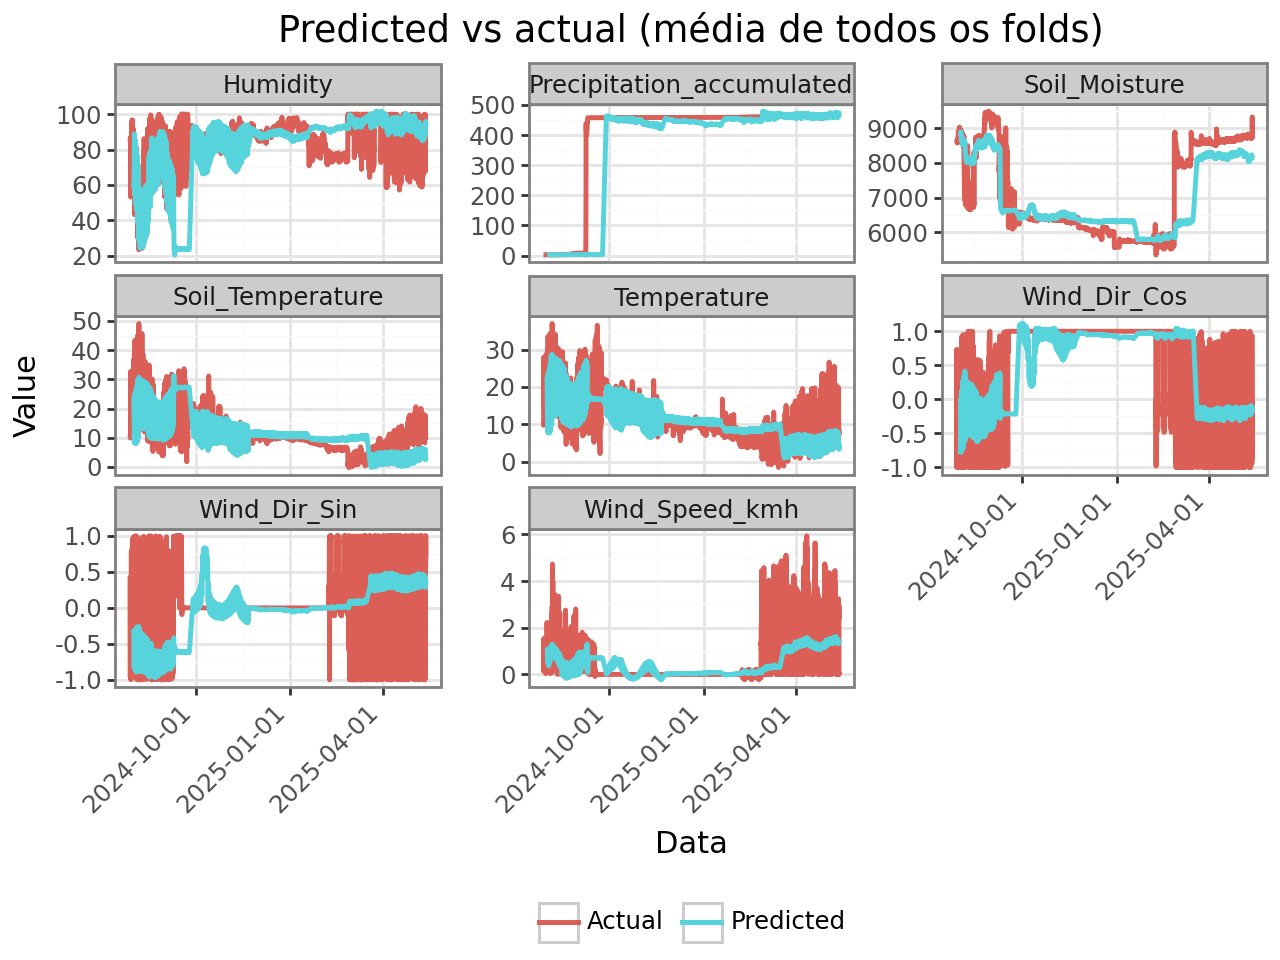

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


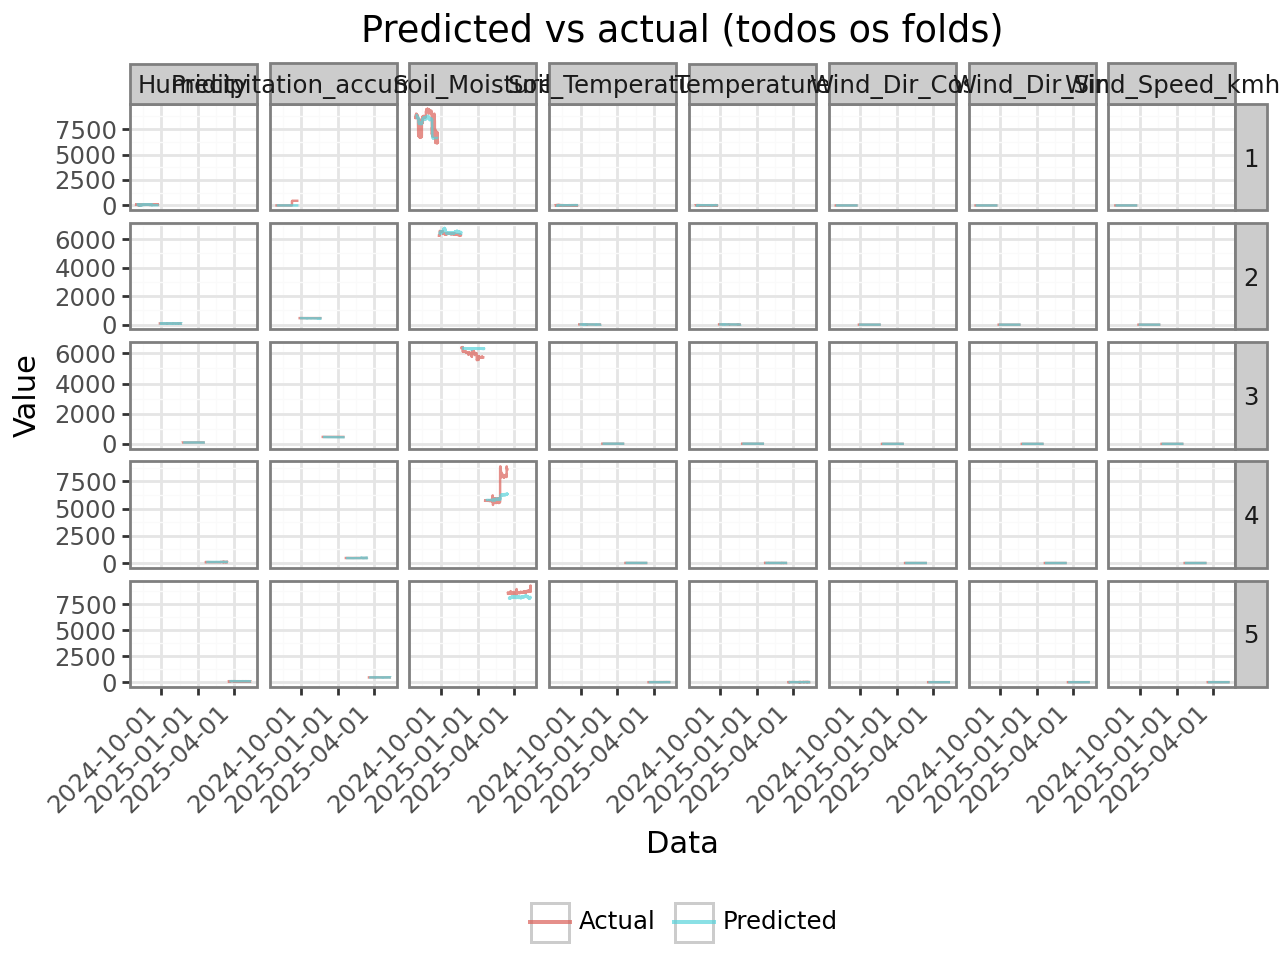

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_207281/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


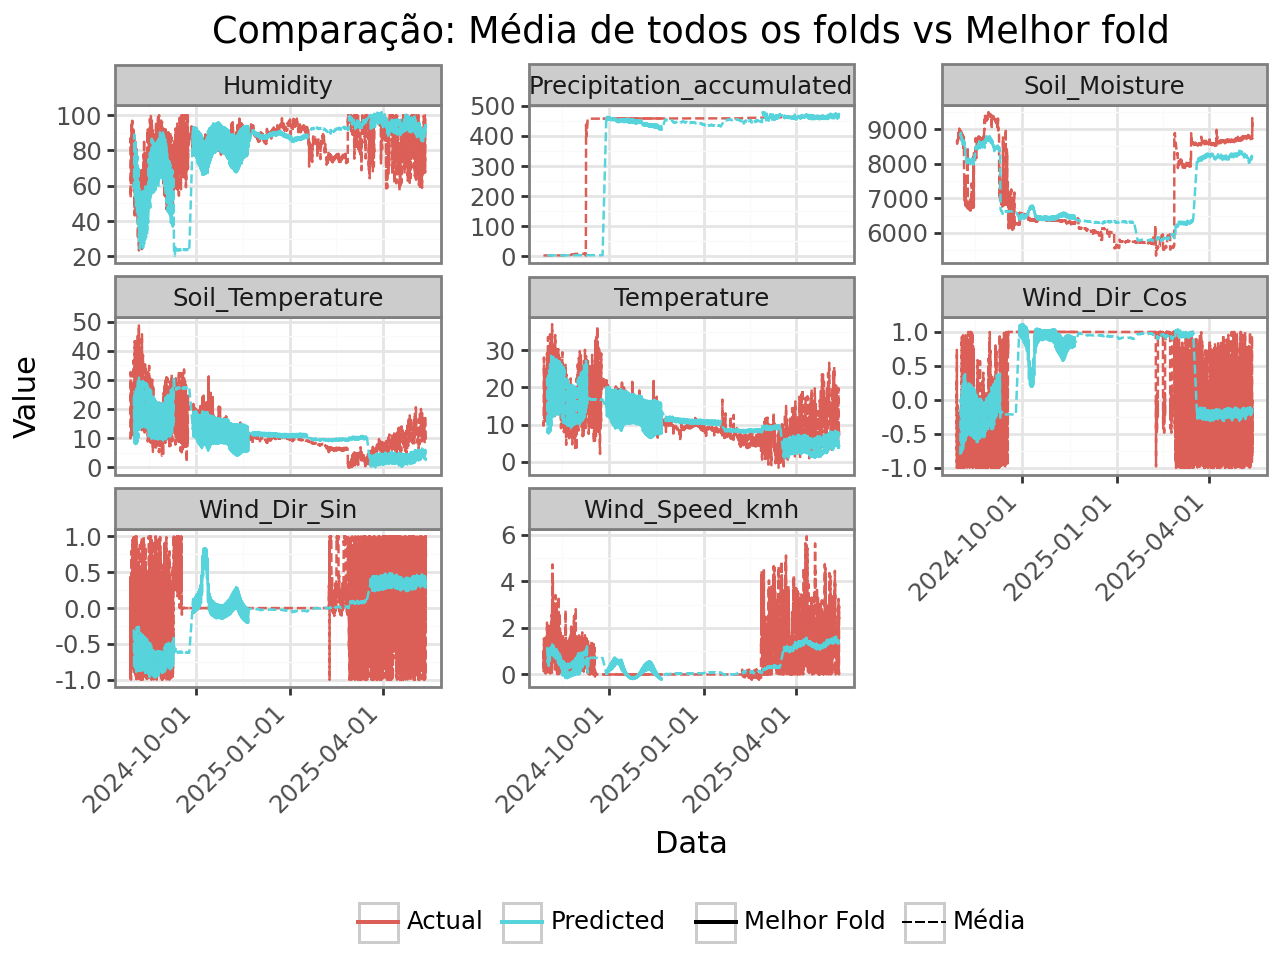

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [15]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [16]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
